In [1]:
import numpy as np
y_axis_labels =['LC','PRF','CNF','PPN',
             'SNr','STN','GPi','GPe',
             'Str','Ctx','SNc','Th']


d_h = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
    [0, -1, -1, -1, 0, 0, 0, 0, -1, 0, -1, -1],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, -1, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1],
    [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0],
    [0, 0, 0, 0, -1, 0, -1, -1, -1, 0, -1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, -1, 1, -1, -1, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

d_pd = np.array([
    [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
    [ 0., -1., -1., -1.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.],
    [ 0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 0., -1.,  0., -1., -1., -1.,  0., -1., -1.,  0., -1., -1.],
    [ 0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,  0.],
    [ 0.,  0.,  0.,  0., -1.,  0., -1., -1., -1.,  0., -1.,  0.],
    [ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.]])

#np.fill_diagonal(d_h, 0)
#np.fill_diagonal(d_pd, 0)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # Importing odeint for ODE solutions

In [3]:

# Parameters
num_oscillators = 12
initial_phase = np.array([2.70942126, 5.76723804, 5.37847039, 3.05959892, 6.02776251,
                          2.09733245, 5.08761267, 0.90470648, 3.80863463, 4.4018627,
                          4.37170568, 4.3379831]).astype(np.float32)  # Example of random initial phases
#initial_phase = np.array([2.97965144, 2.88041689, 5.31820391, 1.47234643, 3.47313868,
#       0.78454326, 3.70524275, 2.65256775, 0.16683834, 3.66548892,
#       5.46139337, 5.75232834])

#np.array([1.13878832, 4.6177762 , 1.05511027, 6.27171308, 2.76710296,
#       0.35217278, 3.80883946, 1.16508376, 3.82968581, 5.30474866,
#       3.11110129, 4.21951334])

omega = torch.full((num_oscillators,), 20.0)  # Frequency of oscillators as a tensor
K = 1.0  # Coupling strength

# Adjacency matrix A (fully connected for simplicity)
A = torch.tensor([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
    [ 0., -1., -1., -1.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.],
    [ 0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 0., -1.,  0., -1., -1., -1.,  0., -1., -1.,  0., -1., -1.],
    [ 0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,  0.],
    [ 0.,  0.,  0.,  0., -1.,  0., -1., -1., -1.,  0., -1.,  0.],
    [ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
    [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.]], dtype=torch.float)
# Hyperparameters
learning_rate = 0.01  # Adjusted learning rate for better convergence
num_epochs = 100  # Increased epochs
hidden_size = 128  # Increased hidden layer size

In [4]:

# Define the ANN controller
class ANNController(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNController, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, t):
        x = torch.tensor([t], dtype=torch.float32)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        u = self.fc3(x)
        # u = self.fc1(x)
        return u

# Define the Kuramoto model dynamics with control input
def kuramoto_dynamics(t, theta, omega, K, u, A):
    N = len(theta)
    # Calculate the interaction influence using the adjacency matrix A
    interaction = A @ torch.sin(theta[:, None] - theta)  # Matrix multiplication
    dtheta_dt = omega + K * (1 / N) * interaction.sum(dim=1)

    # Add control inputs to specific oscillators
    dtheta_dt[3] += u[0]  # Control input for oscillator GPi
    dtheta_dt[6] += u[1]  # Control input for oscillator GPi
    return dtheta_dt

# Create an instance of the ANN controller
controller = ANNController(input_size=1, hidden_size=hidden_size, output_size=2)
optimizer = optim.Adam(controller.parameters(), lr=learning_rate)

# For analysis
loss_values = []
phase_diff_6_11 = []
phase_diff_6_7 = []
phase_diff_7_11 = []
order_param_6_11 = []
order_param_6_7 = []
order_param_7_11 = []
control_inputs = []  # List for storing control inputs

# After defining your previous setup and inside the training loop, add:
control_energy_values = []  # List to store the control energy
# Training loop
for epoch in range(num_epochs):
    theta_initial = torch.tensor(initial_phase, dtype=torch.float32, requires_grad=False)
    t_span = torch.tensor([0, 0.1])
    # Control input based on current epoch
    u = controller(torch.tensor([[epoch]], dtype=torch.float32))
    # Store the control inputs
    control_inputs.append(u.detach().numpy())
    # Solve the ODE
    theta_t = odeint(lambda t, y: kuramoto_dynamics(t, y, omega, K, u, A),
                     theta_initial, t_span)
    # Compute the cost function J
    j1 = (theta_t[1, 3] - theta_t[1, 10]) ** 2  # Synchronization of phases 6 and 11
    j2 = (torch.abs(theta_t[1, 3] - theta_t[1, 6]) - np.pi) ** 2  # Desynchronization from phase 7
    j3 = (torch.abs(theta_t[1, 6] - theta_t[1, 10]) - np.pi) ** 2  # Desynchronization between phases 7 and 11
    loss = j1 + j2 + j3

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store loss values for visualization
    loss_values.append(loss.item())

    # Store phase differences for plotting later
    phase_diff_6_11.append(theta_t[1, 3] - theta_t[1, 10])
    phase_diff_6_7.append(theta_t[1, 3] - theta_t[1, 6])
    phase_diff_7_11.append(theta_t[1, 6] - theta_t[1, 10])

    # Compute the order parameter for phases 6 and 11
    r_6_11 = torch.abs((torch.exp(1j * theta_t[1, 3]) + torch.exp(1j * theta_t[1, 10])) / 2).item()
    r_6_7 = torch.abs((torch.exp(1j * theta_t[1, 3]) + torch.exp(1j * theta_t[1, 6])) / 2).item()
    r_7_11 = torch.abs((torch.exp(1j * theta_t[1, 6]) + torch.exp(1j * theta_t[1, 10])) / 2).item()

    order_param_6_11.append(r_6_11)
    order_param_6_7.append(r_6_7)
    order_param_7_11.append(r_7_11)


# Convert phase differences to numpy for plotting
phase_diff_6_11 = torch.stack(phase_diff_6_11).detach().numpy()
phase_diff_6_7 = torch.stack(phase_diff_6_7).detach().numpy()
phase_diff_7_11 = torch.stack(phase_diff_7_11).detach().numpy()

# Convert order parameters to numpy for plotting
order_param_6_11 = np.array(order_param_6_11)
order_param_6_7 = np.array(order_param_6_7)
order_param_7_11 = np.array(order_param_7_11)
# Convert control inputs to numpy for plotting
control_inputs = np.array(control_inputs)

In [5]:
# Set global font properties  
b=25
plt.rc('font', size=b, weight='bold')  # Set default font size and weight  
plt.rc('axes', titlesize=b, labelsize=b, titleweight='bold')  # Set title and label sizes with bold weight  
plt.rc('xtick', labelsize=b)  # Set x-tick label size and weight  
plt.rc('ytick', labelsize=b)  # Set y-tick label size and weight  
plt.rc('legend', fontsize=b)  # Set legend font size and title weight  

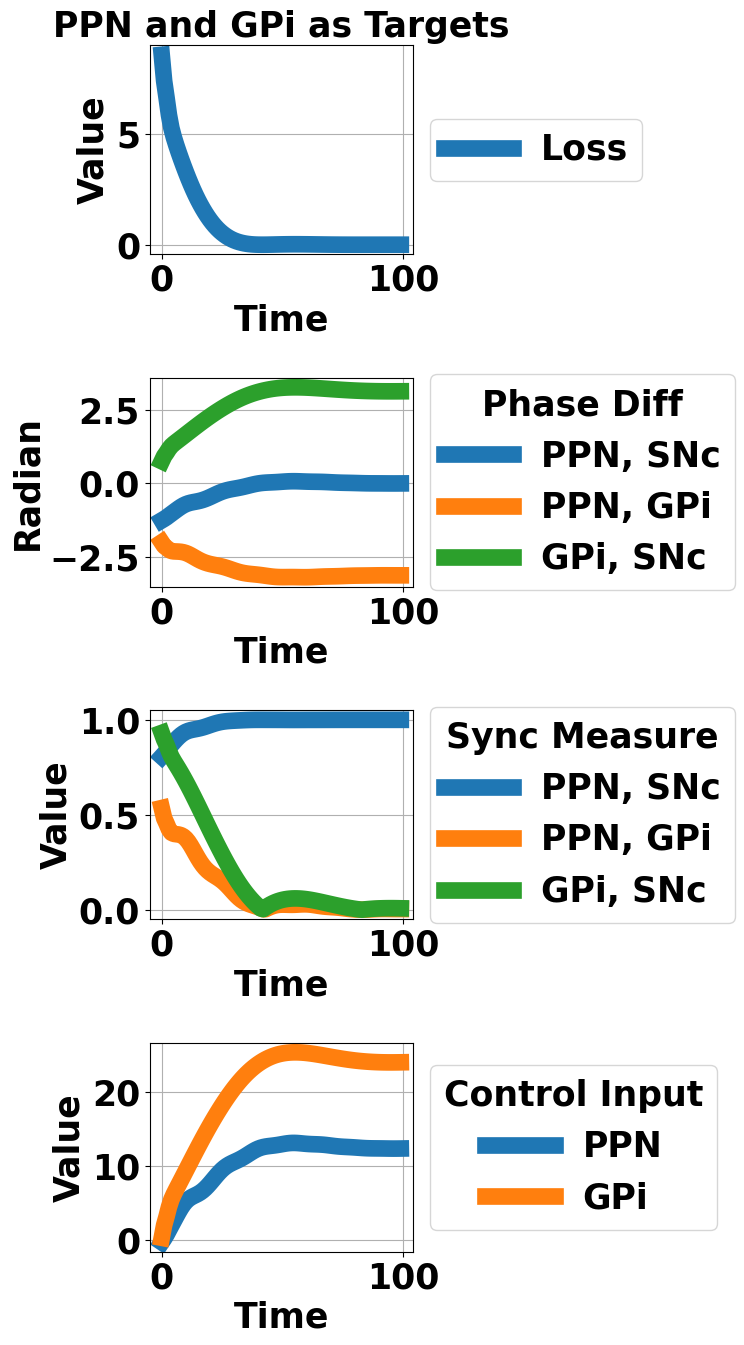

In [6]:
m = 4
n = 1

# Plotting the results
# plt.figure(figsize=(8, 5))
# plt.figure(figsize=(8, 10))
# plt.figure(figsize=(8, 12))
plt.figure(figsize=(8, 14))


a=12
#######################################################################################################
#######################################    STN, GPi, SNc  ###################################
# Subplot for Loss
plt.subplot(m, n, 1)
plt.plot(loss_values, label='Loss',  linewidth=a)
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.title('PPN and GPi as Targets',fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.grid()  

# Subplot for Phase Differences
plt.subplot(m, n, 2)
plt.plot(phase_diff_6_11, label='PPN, SNc',  linewidth=a)
plt.plot(phase_diff_6_7, label='PPN, GPi',  linewidth=a)
plt.plot(phase_diff_7_11, label='GPi, SNc',  linewidth=a)
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Radian',fontweight='bold')
#plt.title('Phase Differences Over Time')
plt.legend(title='Phase Diff', loc='center left', bbox_to_anchor=(1, 0.5))  
plt.grid()  

# Subplot for Order Parameters
plt.subplot(m, n, 3)
plt.plot(order_param_6_11, label='PPN, SNc',  linewidth=a)
plt.plot(order_param_6_7, label='PPN, GPi',  linewidth=a)
plt.plot(order_param_7_11, label='GPi, SNc',  linewidth=a)
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
#plt.title('Order Parameter Over Time')
plt.legend(title='Sync Measure', loc='center left', bbox_to_anchor=(1, 0.5))  
plt.grid()  

# Subplot for Control Inputs
plt.subplot(m, n, 4)
plt.plot(control_inputs[:,0], label='PPN', linestyle='-',  linewidth=a)
plt.plot(control_inputs[:,1], label='GPi', linestyle='-',  linewidth=a)
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
#plt.title('Control Input Evolution Over Time')
plt.legend(title='Control Input', loc='center left', bbox_to_anchor=(1, 0.5))  
plt.grid()  

plt.tight_layout()
plt.savefig('results/ControlledDynamics_PPNGPi.png',bbox_inches='tight', transparent=True)
plt.show()


In [10]:
# Set global font properties  
b=22
plt.rc('font', size=b, weight='bold')  # Set default font size and weight  
plt.rc('axes', titlesize=b, labelsize=b, titleweight='bold')  # Set title and label sizes with bold weight  
plt.rc('xtick', labelsize=b)  # Set x-tick label size and weight  
plt.rc('ytick', labelsize=b)  # Set y-tick label size and weight  
plt.rc('legend', fontsize=b)  # Set legend font size and title weight  

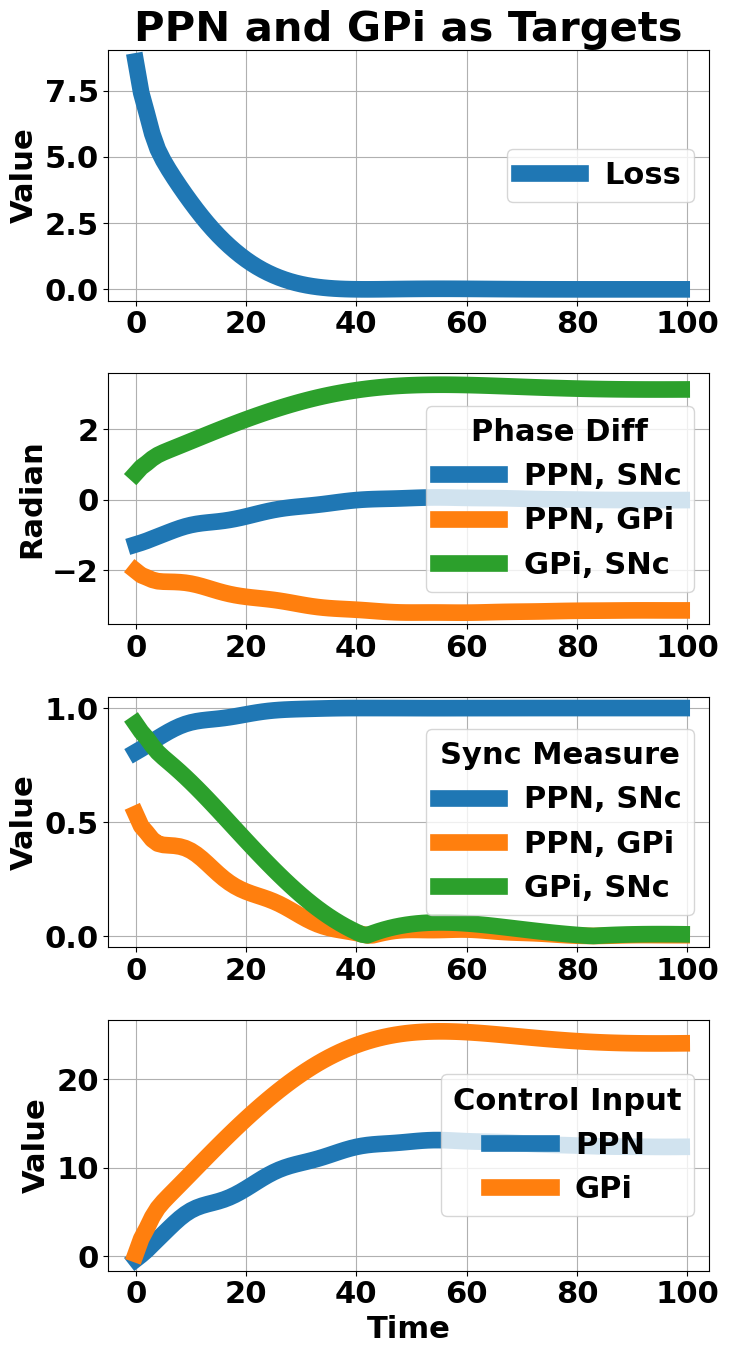

In [12]:
m = 4
n = 1

# Plotting the results
# plt.figure(figsize=(8, 5))
# plt.figure(figsize=(8, 10))
# plt.figure(figsize=(8, 12))
plt.figure(figsize=(8, 14))


a=12
#######################################################################################################
#######################################    STN, GPi, SNc  ###################################
# Subplot for Loss
plt.subplot(m, n, 1)
plt.plot(loss_values, label='Loss',  linewidth=a)
# plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.title('PPN and GPi as Targets',fontweight='bold', fontsize=30)
plt.legend(loc='center right')  
plt.grid()  

# Subplot for Phase Differences
plt.subplot(m, n, 2)
plt.plot(phase_diff_6_11, label='PPN, SNc',  linewidth=a)
plt.plot(phase_diff_6_7, label='PPN, GPi',  linewidth=a)
plt.plot(phase_diff_7_11, label='GPi, SNc',  linewidth=a)
# plt.xlabel('Time',fontweight='bold')
plt.ylabel('Radian',fontweight='bold')
#plt.title('Phase Differences Over Time')
plt.legend(title='Phase Diff', loc='center right')  
plt.grid()  

# Subplot for Order Parameters
plt.subplot(m, n, 3)
plt.plot(order_param_6_11, label='PPN, SNc',  linewidth=a)
plt.plot(order_param_6_7, label='PPN, GPi',  linewidth=a)
plt.plot(order_param_7_11, label='GPi, SNc',  linewidth=a)
# plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
#plt.title('Order Parameter Over Time')
plt.legend(title='Sync Measure', loc='center right')  
plt.grid()  

# Subplot for Control Inputs
plt.subplot(m, n, 4)
plt.plot(control_inputs[:,0], label='PPN', linestyle='-',  linewidth=a)
plt.plot(control_inputs[:,1], label='GPi', linestyle='-',  linewidth=a)
plt.xlabel('Time',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
#plt.title('Control Input Evolution Over Time')
plt.legend(title='Control Input', loc='center right')  
plt.grid()  

plt.tight_layout()
plt.savefig('results/ControlledDynamics_PPNGPi.png',bbox_inches='tight', transparent=True)
plt.show()
